# nb 01: read data from ```hrr_cobot```

This notebook outlines and tests various modules available in the ```hrr_cobot_robot``` and ```hrr_common``` package.

You may also refer to our [internal project-docu](https://hr_recycler.pages.gitlab.lrz.de/hrr_cobot/) for additional help.

Updated version after COMAU-integration

**NOTE: For testing, please forward to the last cell, it is sufficient for testing the individual modules**

## Imports / Packages needed

In [1]:
# math and robotics
import numpy as np
import quaternion

# plotting 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# simulated robot content and helpers
import hrr_cobot_robot as hrr_rob
import hrr_controllers
from hrr_common.utils import pose_error

# ROS
import rospy

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
%matplotlib notebook

## READING robot data

Below we show the basic usage of communicating with the ```hrr-cobot```

This notebook assumes that you have started the COMAU RAcer 5 robot via ros according to the instructions
in the 

- [hrr_cobot_robot/README](https://git.lsr.ei.tum.de/hr_recycler/hrr_cobot/-/blob/master/hrr_cobot_robot/README.md)
- and / or the refer the [Robot start-up in the wiki](https://wiki.tum.de/x/UIOiL).

In short, we ran:

```bash
 ~                                      hrr with schrottgott@hrrcobotLinux54 at  11:08:09
❯ roslaunch hrr_cobot_robot hrr_cobot_hw.launch gripper_type:="nothing"
```

After this, each class instance / API handle is expected to be initiated by the function ```from_ros()```
**if** the ros-paramters have been set / loaded to the [ROS paramter-server](http://wiki.ros.org/Parameter%20Server).

_the ```gripper_type="nothing"``` is optional and just added as we have no gripper in the examples below_


###### connect to ROS 

optionally set the ```ROS_IP``` and ```ROS_MASTER_URI``` directly form this notebook, as
the setup above spawns the ros-setup from the real-time client, i.e. ```hrrN3511rt2004.lsr.ei.tum.de```

In [2]:
rospy.init_node("hrr_cobot_tutorial01")

### robot state (```hrr_cobot_robot.RobotState```)

This class interface implements a class handle that wraps ```joint-state``` information. 
You can check this topic in a terminal via

```bash
~ ··········································································· 5s │ hrr Py │ 17:06:02 
❯ rostopic echo /hrr_cobot/joint_states
# ...
header: 
  seq: 18806
  stamp: 
    secs: 1632755161
    nsecs: 653168686
  frame_id: ''
name: 
  - joint_1
  - joint_2
  - joint_3
  - joint_4
  - joint_5
  - joint_6
  - jr3msr_joint
position: [-0.000730169762391597, 0.0003336603404022753, -1.5704600811004639, 0.0039870161563158035, 1.5723326206207275, -0.008724238723516464, 0.0]
velocity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
effort: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
---
header: 
  seq: 18807
  stamp: 
    secs: 1632755161
    nsecs: 658375175
```


When trying to set this class instance, it will will thrown an error as the dedicated ros-parameter is not yet set properly.

The required ROS-parameter is given as 

```joint_state_topic_name```

which defines the joint-state topic, as well as the optional

```joint_names```

which defines the names of the robot-joints in the URDF.

In [3]:
robot_status = hrr_controllers.RobotState.from_ros()

TypeError: from_ros() missing 1 required positional argument: 'cobot_prefix'

Thus, we set the dedicated ros-parameter as shown below.
In order to find the respective ros-topic name, you may execute

```bash
❯ rostopic list | grep joint_state
/hrr_cobot/joint_states
```

in a terminal.
Assuming the joint-state ros-topic is named ```/hrr_cobot/joint_states```, we can set the ros-parameter server and 
retest the class handle instantiation.
We can then print the class to ease the current state output.

**NOTES**

> In case you forget to set the ```sleep``` command, the robot will show a zero-vector for the joints
> 
> In contrast to the majority of robot / controller APIs, this interface can be applied to arbitrary robot systems

In [4]:
?hrr_controllers.RobotState.from_ros

In [6]:
rospy.set_param("~joint_state_topic_name", "/hrr_cobot/joint_states")
robot_status = hrr_controllers.RobotState.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
print(robot_status)

q:		[  4.0865   -0.55171 -85.088   -11.11447  77.22678  -2.52394][°]
q_dot:		[0. 0. 0. 0. 0. 0.][rad/s]
tau:		[0. 0. 0. 0. 0. 0.][Nm]


In [5]:
robot_status.q, robot_status.q_deg

NameError: name 'robot_status' is not defined

#### Kinematics utilities / interfaces

In addition to general robot state values, the ``RobotState`` also allows to use the symbiolic Racer model from the ``sim_robots`` python package (c.f.: https://git.lsr.ei.tum.de/hr_recycler/sim_robots).
Thus, on request the ``_kin_model`` attribute is generated via ``_assert_kin_model`` once a function is used that needs said model.

As seen below, the attribute is empty by default.

**Note:**

- depending on the current state of the model, the initial generation may take some seconds. After the model is generated, the processing is fastened
- The IK returns too many solutions by the time of writing as some of them are infeasible for the current solution, so either check your solution or provide the command ``check=True`` to the function as shown below

In [6]:
robot_status._kin_model

NameError: name 'robot_status' is not defined

The main functions in use are the forward-kinematics and inverse-kinematics, implemented as the functions below

```ipython
?robot_status.FK
?robot_status.IK
```

In [7]:
T = robot_status.FK(robot_status.q)
T

NameError: name 'robot_status' is not defined

In [10]:
robot_status._kin_model

In [ ]:
# ISSUE to be resolved with sim_robots
# for i, q in enumerate(robot_status.IK(T)):
#     err = np.linalg.norm(pose_error(robot_status.FK(q), T))
#     if err > 1e-3:
#         rospy.logerr(f"solution: #{i} leads to Cartesian error of {err}")

In [ ]:
# ISSUE to be resolved with sim_robots
# errors = {}
# for i, q in enumerate(robot_status.IK(T, check=True)):
#     err = np.linalg.norm(pose_error(robot_status.FK(q), T))
#     if err > 1e-3:
#         rospy.logerr(f"solution: #{i} leads to Cartesian error of {err}")
#     errors[i] = err
# errors

### TP5 state (```hrr_cobot_robot.ComauRobotState```)

The Tp5 state cobot is an extension of the robot state instance and reads the output of the ```tp5_state_controller```

This controller expects the following ROS-parameters to be set:

| param name |  explanation|  default |
| ----------| -----------|  --------  |
| ```joint_names``` | the names of the **robot**-joints in the URDF | (joint_1:6) |
| ```sns_frame``` | name of the sensor-tracking / ee-link in the tp5 controller | "tcp_controller" |
| ```base_frame``` | name of the robot base-link, i.e. sns-tracking reference frame | "base_link" |
| ```joint_state_topic_name``` | topic name for the **joint state controller** (see above) | |
| ```tp5_topic_name``` | topic name for the **tp5 state controller** |  |

parameters without default values need to be set to the ros-param server before instantiation.

the default value for the ```tp5_topic_name``` is found via

```bash
❯ rostopic list | grep comau_cartesian_data
/hrr_cobot/comau_robot_state_controller/comau_cartesian_data
```

Reading from this topic is identical to the commands above.
So we can now set the parameters and instantiate the robot handle.

In contrast to the handle above, this class gives not only information about the joint state but also the
Cartesian sensor data readings.
the outputs are explained as

- joint-data -> joint state data
- pos / quat -> transformation obtained from tf2ros from base->sns-frame
- tool-pos / rpy -> sensory output from the ```tp5 state message```
- robot-status -> the current robot status, e.g. ```moving, ready, error, terminate``` (see ```comau_driver```)

In [8]:
# rospy.set_param("~joint_state_topic_name", "/hrr_cobot/joint_states")
# rospy.set_param("~tp5_topic_name", "/hrr_cobot/comau_robot_state_controller/comau_cartesian_data")
comau_status = hrr_controllers.ComauRobotState.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
print(comau_status)

q:		[  -7.1022    43.30821 -104.98208   -3.68821   30.60733  -44.85058][°]
q_dot:		[0. 0. 0. 0. 0. 0.][rad/s]
tau:		[0. 0. 0. 0. 0. 0.][Nm]
pos:		[0.54624 0.0707  0.25225][m]
quat:		0.00135 <[0.34937 0.93679 0.01918]>
tool-pos:	[0.54624 0.0707  0.25225][m]
tool-rpy:	[-139.11102    0.91296 -177.99431][°]
robot-status:	ready


this class handle allows some custom command readouts besides accessing the current end-effector

- position
- quaternion-orientatoin
- Rotation matrix orientation
- SE(3) pose
- robot-status as human readable string

as the robot handle allows to check if the current configuration is sufficiently close to the calibration pose of the robot, as outlined below

In [20]:
np.rad2deg(comau_status.tool_rpy)inematics - transformation tester.ipynb

array([-174.34862,   18.89359, -169.9353 ])

In [12]:
comau_status.pos

array([ 0.45069, -0.01712,  0.74698])

In [13]:
comau_status.quat

quaternion(0.159034650418581, 0.062821325265939, 0.980731531264724, 0.0944834622630905)

In [14]:
comau_status.R

array([[-0.94152,  0.09317,  0.32381],
       [ 0.15327,  0.97425,  0.16534],
       [-0.30007,  0.20531, -0.93156]])

In [15]:
comau_status.T_B_E

array([[-0.94152,  0.09317,  0.32381,  0.45069],
       [ 0.15327,  0.97425,  0.16534, -0.01712],
       [-0.30007,  0.20531, -0.93156,  0.74698],
       [ 0.     ,  0.     ,  0.     ,  1.     ]])

In [16]:
robot_status.q

array([ 0.07132, -0.00963, -1.48507, -0.19398,  1.34786, -0.04405])

In [17]:
comau_status.can_calibrate

False

In [18]:
comau_status.robot_status

'ready'

### Force-Torque State handles

#### Simple FT-Sensor Handle (```hrr_cobot_robot.FTData```)

This class instance expects the ```ft_sensor_topic``` ros param to be set.

```bash
rostopic list | grep ft
/hrr_cobot/ft_sensor
```

In [21]:
rospy.set_param("~ft_sensor_topic_name", "/hrr_cobot/ft_sensor")
ft_status = hrr_controllers.FTData.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
print(ft_status)

current force:	[-0.36255 -0.22559 -0.02637] [N]
current torque:	[ 0.27374 -0.48706  0.10181] [Nm]


this handle allows to access the sensor data separately for wrench, force and torque and protects
the raw sensor reading, which is found in ```_wrench```.

This handle allows for a calibrated read-out if the parameters have been set correctly either fromm the paramter server (see ```read_params```) or from file (see ```load_offset```).

Once the calibratoin values have been set, the state handle needs to be updated via ```update_load```
as this depends on the current end-effect to base frame orientation.
The final calibrated value is then to be found in ```wrench_calib```

In [29]:
ft_status.f, ft_status.tau, ft_status.wrench

(array([-15.01282,  -9.71631,  25.41797]),
 array([ 7.005  , -8.31848,  3.21539]),
 array([-15.01282,  -9.71631,  25.41797,   7.005  ,  -8.31848,   3.21539]))

In [31]:
ft_status._wrench

array([ 0.41199, -0.65259, -4.21875,  1.07391, -0.94208,  0.18665])

In [30]:
ft_status.offset

array([0., 0., 0., 0., 0., 0.])

In [36]:
ft_status.wrench, ft_status.wrench_calib

(array([ 0.33783, -0.6123 , -3.95508,  1.0318 , -0.90363,  0.19513]),
 array([ 0.33783, -0.6123 , -3.95508,  1.0318 , -0.90363,  0.19513]))

#### FT-Sensor Buffer handle (```hrr_cobot_robot.FTBuffer```)

This is pretty similar to the simple FT-sensor handle but allows to store the FT-reading in a buffer and apply a 
[Savitkzy-Golay-filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html)
to reduce the SNR of the recorded data.

The procedure is pretty similar as shwon below, but in addition allows to estimate:

- sensor noise 
- return ```in_contact``` by comparing filtered data against sensor noise


In [33]:
ft_buf_status = hrr_controllers.FTBuffer.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
print(ft_buf_status)

current force:	[ 0.40375 -0.58813 -4.08691] [N]
current torque:	[ 1.02478 -0.91003  0.16968] [Nm]
current wrench:	[ 0.50028 -0.79409 -5.31901  1.35366 -1.16681  0.22934] [N,Nm]
=>in contact:	True


In [34]:
ft_buf_status.N, ft_buf_status.window_size

(101, 49)

In [40]:
ft_buf_status.μ, ft_buf_status.σ, ft_buf_status.wrench

(array([ 0.37683, -0.62283, -4.04332,  1.0466 , -0.90623,  0.18539]),
 array([0.02272, 0.02506, 0.06399, 0.01421, 0.01338, 0.01184]),
 array([ 0.37903, -0.62842, -3.98145,  1.05286, -0.92285,  0.18665]))

the plot below shows the difference of measured force versus calibrated and filtered + calibrated force

<IPython.core.display.Javascript object>


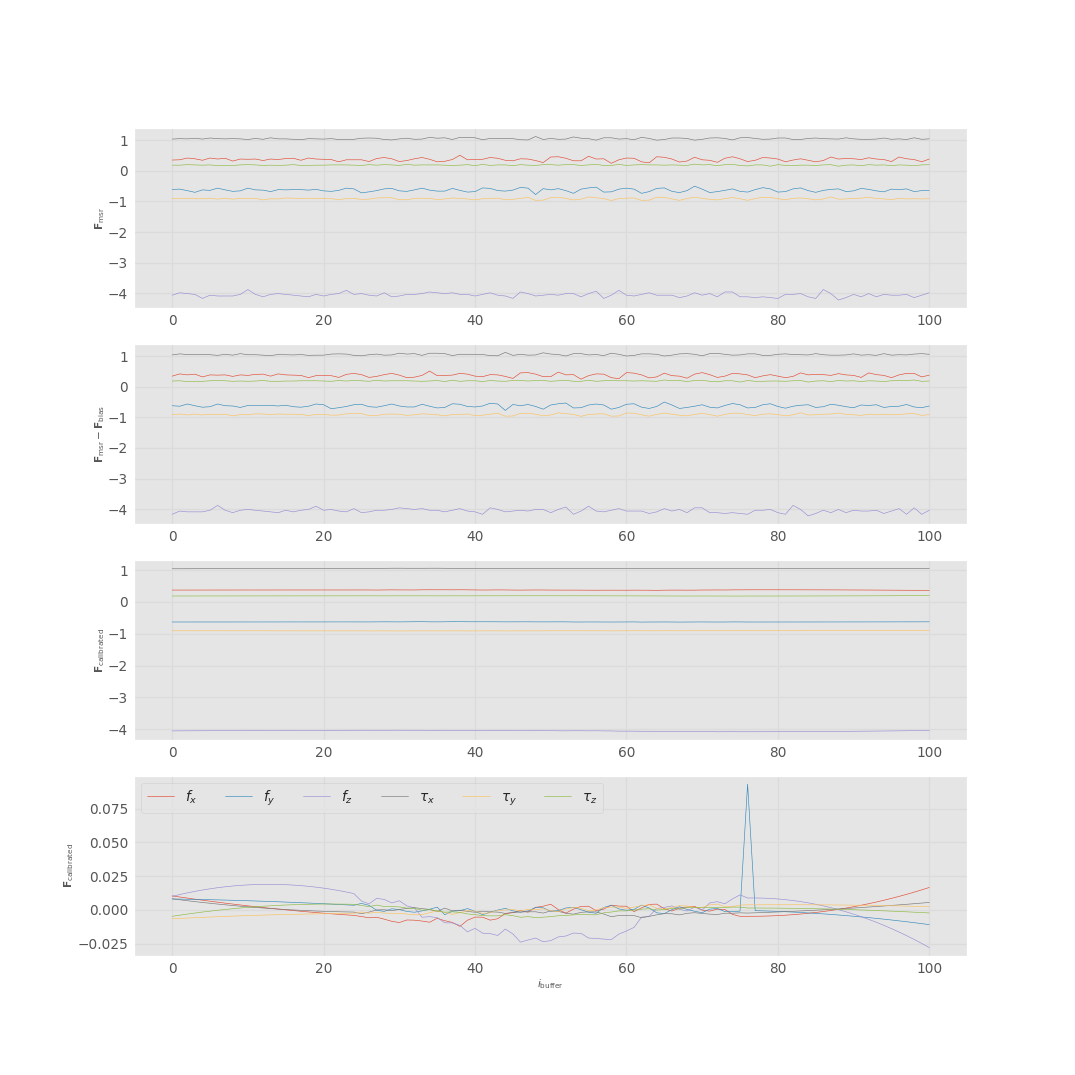

In [41]:
fig = plt.figure(figsize=(12,12))
# F msr
ax = fig.add_subplot(411)
ax.plot(ft_buf_status._wrench_buf.T)
ax.set_ylabel(r'${\bf F}_\mathrm{msr}$')

# Fmsr - Fbias
ax = fig.add_subplot(412)
ax.plot(ft_buf_status._wrench_buf.T - ft_buf_status.offset)
ax.set_ylabel(r'${\bf F}_\mathrm{msr} -{\bf F}_\mathrm{bias} $')

# F filtered
ax = fig.add_subplot(413)
plt.plot((ft_buf_status.filtered_buf.T - ft_buf_status.bias))
ax.set_ylabel(r'${\bf F}_\mathrm{calibrated}$')

# F filtered after reset
ax = fig.add_subplot(414)
ft_buf_status.reset_bias()
plt.plot((ft_buf_status.filtered_buf.T - ft_buf_status.bias))
ax.set_ylabel(r'${\bf F}_\mathrm{calibrated}$')

ax.set_xlabel(r'$i_{\mathrm{buffer}}$')
ax.legend(['$f_x$','$f_y$', '$f_z$', 
           r'$\tau_x$',r'$\tau_y$', r'$\tau_z$'], ncol=6);

Even though not recommended, the ```FTBuffer``` contains a quick hack for sensor-calibration via ```reset_bias```
as shown in the last plot above.

In [42]:
ft_buf_status.wrench, ft_buf_status.wrench_calib

(array([ 0.36255, -0.68481, -3.92871,  1.07391, -0.94208,  0.18665]),
 array([-0.01436, -0.05512,  0.12661,  0.02113, -0.03725, -0.00361]))

## Shortcut

all parameters shown above can also be loaded by a util-function callled ```load_default_parameters```
where all parameters are loaded within the name-space of the robot in the current node

to test this, restart the kernel and run only the cell below

In [ ]:
import rospy
import numpy as np

from hrr_controllers import (
    RobotState,
    ComauRobotState,
    FTData,
    FTBuffer
)
import hrr_cobot_robot as hrr_rob

# ROS
import rospy
np.set_printoptions(precision=5, suppress=True)

try:
    rospy.init_node("hrr_cobot_tutorial_quick_01")
except rospy.ROSException:
    print('ROS is already initialized')
rob = RobotState.from_ros("/hrr_cobot")
com_rob = ComauRobotState.from_ros("/hrr_cobot")
ft = FTData.from_ros("/hrr_cobot")
ftb = FTBuffer.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
print(f'\nRobotState:\n{rob}')
print(f'\nComauRobotState:\n{com_rob}')
print(f'\nFTData:\n{ft}')
print(f'\nFTBuffer:\n{ftb}')